# Example:  Eikonal Inversion

This example demonstrates how to use `jInv` for estimating the slowness parameter in the 3D Eikonal equation. Our example is motivated by travel time tomography which, is a geophysical imaging technique. Here, the Eikonal equation is used to model the first arrival time of a seismic wave orinating from some point on the surface of the 3D volume. The first arrival time of a wave originating in $x_j\in\Omega \subset\mathbb{R}^3$ is modeled by the function $u_j : \Omega \to \mathbb{R}^+$ that satisfies

$$
    | \nabla u_j(x) |^2 = m(x), \quad x \in \Omega, \quad u_j(x_j)=0 ,
$$

where $m : \Omega \to \mathbb{R}^+$ is the squared slowness that needs to be recovered. Measuring the travel time at a number of locations on the surface for each source, our goal is to solve the inverse problem

\begin{equation*}
		\min_{m} \sum_{j} \| P_j^\top u_j(m) - d_{j}\|^2 + \alpha \| L m\|^2 
        \quad \text{ subject to} \quad m_L \leq m \leq x_H
\end{equation*}

where 

* $m$ - is the squared slowness
* $u_j$ - is the travel time for the $j$th source
* $d_{j}$ - is the measured data for the $j$th source
* $P_j$ - are the receiver matrices
* $\alpha>0$ and $L$ is the regularization parameter and operator, respectively
* $m_L,m_H$ are lower and uppter bounds on the model

## References

This experiment is also described in [1]. The fast marching method used to solve the Eikonal equation is presented in [2]. The test data here is generated using jInv and based on the 3D SEG/EAGE model of a salt reservoir described in [3]. Thus, please see and reference the following papers when using this example:

[1]  Ruthotto L, Treister E, Haber E: [jInv - a flexible Julia package for PDE parameter estimation](http://arxiv.org/abs/1606.07399), arXiv:1606.0739 [cs.MS] 2016

[2] Treister E, Haber E: [A fast marching algorithm for the factored eikonal equation](http://dx.doi.org/10.1016/j.jcp.2016.08.012), Journal of Computational Physics, 324(1), p. 210–225, 2016

[3] F. Aminzadeh, B. Jean, and T. Kunz. 3-D salt and overthrust models. Society of Exploration Geophysicists, 1997.

## Add parallel workers

The solver for the forward problems is implemented in our package [`FactoredEikonalFastMarching.jl`](https://github.com/JuliaInv/FactoredEikonalFastMarching.jl)  and is based on the fast marching method described in [2]. The method is difficult to parallelize, however, as common in practice we have multiple measurements that need to be simulated. Our package automatically uses this potential for parallelization and uses all available workers. 

So, before you start this experiment we recommend you add workers. Here, we just use local workers, but you may also use MPI or SSH to connect to remote workers. The parallelism in `jInv` is designed to be communication efficient. 

In [1]:
addprocs(8)  # add workers 

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [2]:
using MAT
using PyPlot
using EikonalInv
using jInv.InverseSolve
using jInv.Mesh
using jInv.ForwardShare
using jInv.Utils
using jInvVis

## Load Data

Some test data is given in the mat file `exEikonal.mat`. 

In [3]:
matfile   = matread("exEikonal.mat")
Receivers = matfile["Receivers"]# sparse matrix of discrete receivers
Sources   = matfile["Sources"] # sparse matrix of discrete sources
dobs      = matfile["dobs"]    # observations simulated with true model
dobs0     = matfile["dobs0"]   # observations simulated for reference model
n         = matfile["n"]       # size of mesh used for the model
domain    = matfile["domain"]  # domain size
slowref   = matfile["slowref"] # reference slowness, serves as starting guess
mref      = matfile["mref"];   # reference model
Wd        = matfile["Wd"];     # weighting matrix for misfit;

## Visualize Data

Here, we visualize the measured data for some selected sources. For comparison, we show the data obtained using the true slowness `dobs` and the one for the reference slowness `slowref` that is used as a starting guess for the inversion. Looking at the difference of the data, gives us some clue about the experiment.


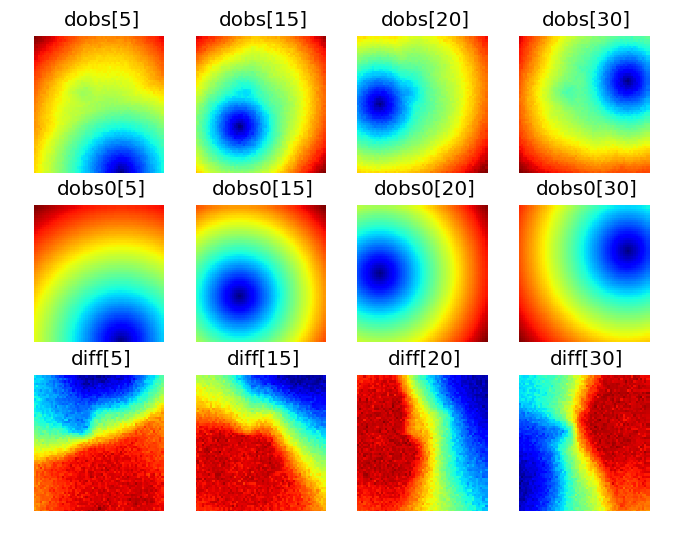

In [4]:
ids = [5 15 20 30] # pick sources you want to see

MD = getRegularMesh(domain[1:4],[60 60])
viewD(data) = (viewImage2D(data,MD); axis("off"))
subplot(3,4,1)
viewD(dobs[:,ids[1]])
title("dobs[$(ids[1])]")
subplot(3,4,2)
viewD(dobs[:,ids[2]])
title("dobs[$(ids[2])]")
subplot(3,4,3)
viewD(dobs[:,ids[3]])
title("dobs[$(ids[3])]")
subplot(3,4,4)
viewD(dobs[:,ids[4]])
title("dobs[$(ids[4])]")

subplot(3,4,5)
viewD(dobs0[:,ids[1]])
title("dobs0[$(ids[1])]")
subplot(3,4,6)
viewD(dobs0[:,ids[2]])
title("dobs0[$(ids[2])]")
subplot(3,4,7)
viewD(dobs0[:,ids[3]])
title("dobs0[$(ids[3])]")
subplot(3,4,8)
viewD(dobs0[:,ids[4]])
title("dobs0[$(ids[4])]")

subplot(3,4,9)
viewD((dobs-dobs0)[:,ids[1]])
title("res0[$(ids[1])]")
subplot(3,4,10)
viewD((dobs-dobs0)[:,ids[2]])
title("res0[$(ids[2])]")
subplot(3,4,11)
viewD((dobs-dobs0)[:,ids[3]])
title("res0[$(ids[3])]")
subplot(3,4,12)
viewD((dobs-dobs0)[:,ids[4]])
title("res0[$(ids[4])]");

*Interpretation : * comparing the first and second row (see also the difference plot) we can see that the simulated data using the true and reference slowness differ. This is a good starting point for the inversion. In fact, the difference image hints that there is a change in slowness in the center of the domain.

## Setup Meshes

In our Eikonal forward solver, the travel time and slowness are discretized on a nodal grid. This is in contrast to other jInv modules. To make this seamless, we use a shifted grid.

In [5]:
h           = (domain[2:2:end]-domain[1:2:end])./n
domainNodal = copy(domain); domainNodal[1:2:end] += h./2; domainNodal[2:2:end] -= h./2
Mfwd        = getRegularMesh(domain,n-1)

Minv = getRegularMesh(domain,n)

pFor,contDiv,SourcesSubInd = getEikonalInvParam(Mfwd,Sources,Receivers,false,nworkers())
println("Number of forward problems: $(length(pFor))")


Number of forward problems: 8


Note: The number of forward problems should equal the number of workers you have added to your Julia session!

## Selecting the Active Set

Sometimes we want to include some voxels from the inversion (for example, close to the boundary / sources / receivers). This can be done by the matrix `Iact` by deleting some columns from a sparse identity matrix. If we do that, the size of the model gets smaller and so we need to update the reference model as well.

In [6]:
Iact     = sparse(I,prod(n),prod(n))
mref     = Iact'*mref[:]
mback    = mref - Iact*(Iact'*mref);
slowback = slowref - Iact*(Iact'*slowref);

## Setup Misfit Param

Next, we set up the misfit param for our Eikonal inverse problem. It is important to remember that we have distributed the forward problems among the available workers. To avoid communication, we will therefore also split up the data. Our job is to make sure that the right data ends up in the right misfit param. We do that by using the values in `SourcesSubInd`



In [7]:
# split up observed data and misfit weightings
WD   = Array(Array{Float64},length(pFor));
DOBS = Array(Array{Float64},length(pFor));
for k=1:length(pFor)
    Ik      = SourcesSubInd[k];
    WD[k]   = Wd[:,Ik];
    DOBS[k] = dobs[:,Ik];
end
pMis        = getMisfitParam(pFor,WD,DOBS,SSDFun,Iact,slowback);

## Configure the Inversion

In the next block we set parameters for the inversion. In `jInv` we need to select a regularizer, its parameter, and configure the optimization problem by setting upper- and lower bounds, maximum number of iterations for the outer and inner loop, a preconditioner, and a model function. 

In [8]:
# configure regularization
alpha	   	= 1e-15;
regparams   = [1.0,1.0,1.0,1e-6];
regfun(m,mref,Minv) = wdiffusionReg(m,mref,Minv,Iact=Iact,C = regparams)

# configuer optimization
HesPrec     = getSSORRegularizationPreconditioner(1.0,1e-15,200);
cgit       	= 8; 
pcgTol     	= 1e-1;
maxIter    	= 10;
minUpdate 	= 1e-2;
boundsLow  	= 1.45*ones(size(Iact,2));
boundsHigh 	= 4.5 *ones(size(Iact,2));
maxStep		= 0.1*maximum(boundsHigh);
modfunEik   = velocityToSlowSquared;
pInv = getInverseParam(Minv,modfunEik,regfun,alpha,vec(mref),
         boundsLow,boundsHigh,maxStep=maxStep,pcgMaxIter=cgit,pcgTol=pcgTol,
         minUpdate=minUpdate, maxIter = maxIter,HesPrec=HesPrec);

## Choose Method for Plotting/Storing Intermediate Results

Some inversions might take a long time, so it's useful to store or visualize intermediate results. This way, we can cancel the inversion if, e.g., the regularization parameter is too large/small. The optimization algorithms in jInv provide the current model, the current data and some other info we can use. In this case we just plot the true sigma and the estimated sigma for comparison

*Remark : * interactive plotting does not work in IJulia notebooks. However, if you copy the code to a `.jl` file you will be able to see the plots being updated through the iteration.

In [9]:
plotting = true
function plotIntermediates(mc,Dc,iter,pInv,pMis)
    
	figure(13)
	clf()
	subplot(1,2,1)
    viewOrthoSlices2D(mref,Minv)
    title("starting guess for slowness")
	colorbar()
	subplot(1,2,2)
    viewOrthoSlices2D(mc,Minv)
    title("slowness at iter=$(iter)")
	colorbar()
end

plotIntermediates (generic function with 1 method)

## Run the Inversion

We are ready to solve the inverse problem. Here we use the default method in jInv, which is a projected Gauss Newton method with a projected and preconditioned CG solver. 

i.LS	       F	       R	alpha[1]	   Jc/J0	 #Active
  1.0	3.01e+02	0.00e+00	1.00e-15	1.00e+00	  0
   .1	1.17e+02	5.91e-15			3.87e-01
  2.0	1.17e+02	5.91e-15	1.00e-15	3.87e-01	  0
   .1	4.85e+01	1.83e-14			1.61e-01
  3.0	4.85e+01	1.83e-14	1.00e-15	1.61e-01	  2
   .1	1.84e+01	3.62e-14			6.11e-02
  4.0	1.84e+01	3.62e-14	1.00e-15	6.11e-02	  4
   .1	5.44e+00	6.25e-14			1.81e-02
  5.0	5.44e+00	6.25e-14	1.00e-15	1.81e-02	  9
   .1	1.73e+00	9.42e-14			5.77e-03
  6.0	1.73e+00	9.42e-14	1.00e-15	5.77e-03	 15
   .1	1.09e+00	1.27e-13			3.63e-03
  7.0	1.09e+00	1.27e-13	1.00e-15	3.63e-03	179
   .1	9.93e-01	1.42e-13			3.30e-03
  8.0	9.93e-01	1.42e-13	1.00e-15	3.30e-03	280
   .1	9.63e-01	1.49e-13			3.20e-03
  9.0	9.63e-01	1.49e-13	1.00e-15	3.20e-03	231
   .1	9.44e-01	1.52e-13			3.14e-03
 10.0	9.44e-01	1.52e-13	1.00e-15	3.14e-03	219
   .1	9.31e-01	1.57e-13			3.10e-03


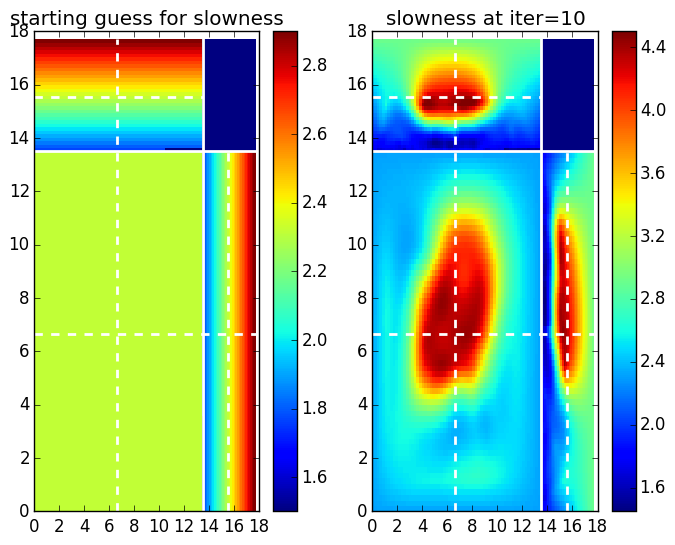

projGNCG iterated maxIter=10 times but reached only stepNorm of 0.06326529466500408 instead 0.01.


In [10]:
mc,Dc,flag,His = projGNCG(copy(mref[:]),pInv,pMis,dumpResults = plotIntermediates);

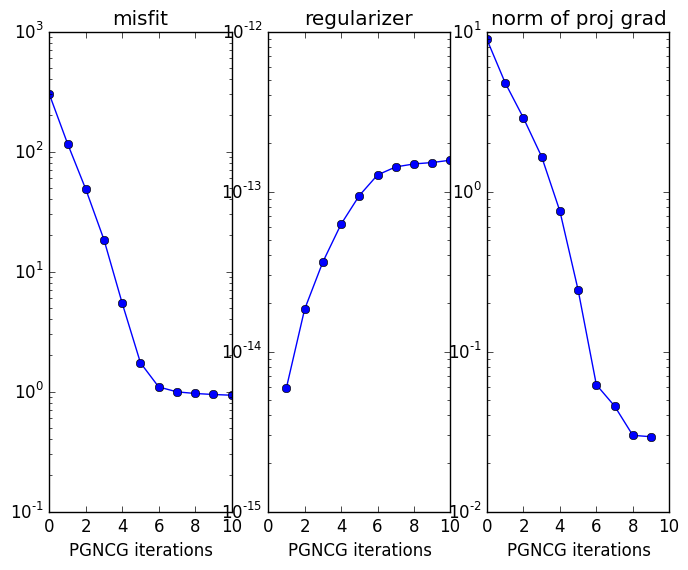

In [11]:
subplot(1,3,1)
semilogy(His.F,"-o")
xlabel("PGNCG iterations")
title("misfit")

subplot(1,3,2)
semilogy(His.Rc,"-o")
xlabel("PGNCG iterations")
title("regularizer");

subplot(1,3,3)
semilogy(His.dJ,"-o")
xlabel("PGNCG iterations")
title("norm of proj grad");

## Visualize residuals

After running the inversion, we should check whether the estimated solution fits the data well. Therfore, we recommend plotting the residual. Here, we do that for a subset of the sources. 

Before we can plot the residual, we need to fetch the simulated data from the workers. By default, jInv does not communicate the data around when not needed (an in the optimization this is the case). 

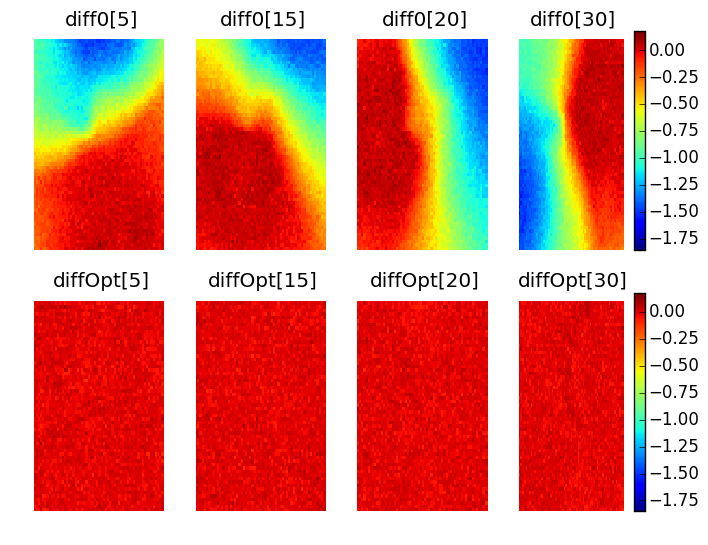

PyObject <matplotlib.colorbar.Colorbar instance at 0x3235e6488>

In [25]:
# fetch and visualize data from workers
DC = 0*dobs
for k=1:length(Dc)
    Ik       = SourcesSubInd[k];
    DC[:,Ik] = fetch(Dc[k])
end

ids = [5 15 20 30] # pick sources you want to see

MD = getRegularMesh(domain[1:4],[60 60])
viewD(data) = (viewImage2D(data,MD,vmin=minimum((dobs-dobs0)),vmax=maximum((dobs-dobs0))); axis("off"))

subplot(2,4,1)
viewD((dobs-dobs0)[:,ids[1]])
title("res0[$(ids[1])]")
subplot(2,4,2)
viewD((dobs-dobs0)[:,ids[2]])
title("res0[$(ids[2])]")
subplot(2,4,3)
viewD((dobs-dobs0)[:,ids[3]])
title("res0[$(ids[3])]")
subplot(2,4,4)
viewD((dobs-dobs0)[:,ids[4]])
title("res0[$(ids[4])]");colorbar()

subplot(2,4,5)
viewD((dobs-DC)[:,ids[1]])
title("resOpt[$(ids[1])]")
subplot(2,4,6)
viewD((dobs-DC)[:,ids[2]])
title("resOpt[$(ids[2])]")
subplot(2,4,7)
viewD((dobs-DC)[:,ids[3]])
title("resOpt[$(ids[3])]")
subplot(2,4,8)
viewD((dobs-DC)[:,ids[4]])
title("resOpt[$(ids[4])]"); colorbar()

## Optional: Save your results



In [29]:
His.Dc = [];
matwrite("exEikonalRes.mat",Dict("mc"=>mc,"His"=>His,"Dc"=>DC))